Code by Max Lashley and Jordan Jomsky

In [79]:
# Import necessary libraries
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations
# For statistical tests:
# shapiro for Shapiro-Wilk test of normality
# ttest_ind for independent samples t-test
# chi2_contingency for chi-squared test of independence
# chisquare for chi-squared goodness-of-fit test
# spearmanr for Spearman rank-order correlation
# kruskal for Kruskal-Wallis H-test
# mannwhitneyu for Mann-Whitney U test
from scipy.stats import shapiro, ttest_ind, chi2_contingency, chisquare, spearmanr, kruskal, mannwhitneyu
import matplotlib.pyplot as plt  # For plotting
import seaborn as sns  # For statistical data visualization
import statsmodels.api as sm  # For statistical models
from statsmodels.formula.api import ols  # For ordinary least squares regression
from sklearn.linear_model import LogisticRegression  # For logistic regression
from sklearn.preprocessing import MinMaxScaler, StandardScaler  # For feature scaling
!pip install pingouin  # Install the pingouin library for statistical analysis
import pingouin as pg  # Import pingouin
import statistics  # For basic statistical calculations
from itertools import combinations # For creating combinations of elements
import warnings
warnings.filterwarnings('ignore') # Ignore warnings to keep the output clean

# **PREPROCESSING**

In [80]:
# Load the datasets
dataset = pd.read_csv("/content/drive/MyDrive/ADNI_BrainAGE_Cog_Scores.csv")
auxdata = pd.read_csv("/content/drive/MyDrive/ADNI_Combined_BrainAGE_data.csv")
amyloiddata = pd.read_csv("/content/drive/MyDrive/ADNI_APOE_subject_info_spreadsheet.csv")

# Preprocess the data
dataset.drop_duplicates(inplace=True, subset = "Subject") # Remove duplicate subjects
completedata = pd.DataFrame() # Create an empty dataframe to store the merged data

# Drop unnecessary columns from the dataset
dataset.drop("RID", axis=1, inplace=True)
dataset.drop("Scan_Name", axis=1, inplace=True)
dataset.drop("DX.group", axis=1, inplace=True)
dataset.drop("Image.Data.ID", axis=1, inplace=True)
dataset.drop("EXAMDATE", axis=1, inplace=True)
dataset.drop("Age", axis=1, inplace=True)
dataset.drop("age", axis=1, inplace=True)
dataset.drop("filename", axis=1, inplace=True)
dataset.drop("DX", axis=1, inplace=True)
dataset.drop("true_age", axis=1, inplace=True)
dataset.drop("predicted_age", axis=1, inplace=True)
dataset.drop("Accelerated.Status", axis=1, inplace=True)
dataset.drop("BrainAGE", axis=1, inplace=True)
dataset.drop("CDRSB", axis = 1, inplace=True)
dataset.drop("ADAS13", axis = 1, inplace=True)
dataset.drop("ADASQ4", axis = 1, inplace=True)
dataset.drop("MMSE", axis = 1, inplace=True)


# Merge data from the three datasets based on the "Subject" column
temp_point = {}
for index, subject in enumerate(dataset["Subject"]):
  if subject in auxdata["Subject"].values and subject in amyloiddata["Subject"].values:
    temp_point = dataset.iloc[index].copy()
    temp_point["aicbv_BrainAGE"] = auxdata.loc[auxdata["Subject"] == subject, "aicbv_BrainAGE"].values[0]
    temp_point["aicbv_predictedage"] = auxdata.loc[auxdata["Subject"] == subject, "predicted_age_AICBV"].values[0]
    temp_point["predicted_age_T1"] = auxdata.loc[auxdata["Subject"] == subject, "predicted_age_T1"].values[0]
    temp_point["t1_BrainAGE"] = auxdata.loc[auxdata["Subject"] == subject, "t1_BrainAGE"].values[0]
    temp_point["predicted_age_combo"] = auxdata.loc[auxdata["Subject"] == subject, "predicted_age_combo"].values[0]
    temp_point["combo_BrainAGE"] = auxdata.loc[auxdata["Subject"] == subject, "combo_BrainAGE"].values[0]
    temp_point["true_age"] = auxdata.loc[auxdata["Subject"] == subject, "true_age"].values[0]
    temp_point = pd.DataFrame([temp_point])
    completedata = pd.concat([completedata, temp_point], ignore_index=True)

# Update the main dataset with the merged data
dataset = completedata.copy()

ordered_ad_levels = ['Normal', 'SMC', 'EMCI', 'MCI', 'LMCI', 'AD']
dataset['AD'] = pd.Categorical(dataset['AD'], categories=ordered_ad_levels, ordered=True)

dataset_no_smc = dataset[dataset['AD'] != 'SMC'].copy()
dataset_no_smc['AD'] = dataset_no_smc['AD'].cat.remove_categories(['SMC'])

dataset_mci_merged = dataset.copy()
dataset_mci_merged['AD'] = dataset_mci_merged['AD'].replace({'EMCI': 'MCI', 'LMCI': 'MCI'})
merged_levels = ['Normal', 'SMC', 'MCI', 'AD']
dataset_mci_merged['AD'] = pd.Categorical(dataset_mci_merged['AD'], categories=merged_levels, ordered=True)
dataset_mci_nosmc = dataset[~dataset['AD'].isin(['SMC'])].copy()
dataset_mci_nosmc['AD'] = dataset_mci_nosmc['AD'].replace({'EMCI': 'MCI', 'LMCI': 'MCI'})
merged_levels_nosmc = ['Normal', 'MCI', 'AD']
dataset_mci_nosmc['AD'] = pd.Categorical(dataset_mci_nosmc['AD'], categories=merged_levels_nosmc, ordered=True)

dataset_ls = {'MCI Merged':dataset_mci_nosmc}

# Create a new dataset from dataset_mci_merged with SMCI and PMCI as separate classes
dataset_smci_pmci = dataset_mci_merged[
    ((dataset_mci_merged['AD'] == 'MCI') & (dataset_mci_merged['group'] == 'Group 4')) |
    ((dataset_mci_merged['AD'] == 'MCI') & (dataset_mci_merged['group'] == 'Group 5'))
].copy()

# Rename MCI based on group
dataset_smci_pmci['AD'] = dataset_smci_pmci.apply(lambda row: 'SMCI' if row['AD'] == 'MCI' and row['group'] == 'Group 4' else ('PMCI' if row['AD'] == 'MCI' and row['group'] == 'Group 5' else row['AD']), axis=1)

# Define and set ordered categories for the new AD column
ordered_smci_pmci_levels = ['SMCI', 'PMCI']
dataset_smci_pmci['AD'] = pd.Categorical(dataset_smci_pmci['AD'], categories=ordered_smci_pmci_levels, ordered=True)

# Add the new dataframe to the dictionary
dataset_ls['SMCI_PMCI'] = dataset_smci_pmci

display(dataset.head())

,Subject,AD,bad?,Sex,time.since.bl,group,aicbv_BrainAGE,aicbv_predictedage,predicted_age_T1,t1_BrainAGE,predicted_age_combo,combo_BrainAGE,true_age
0,002_S_0295,Normal,False,M,NaN,Group 1,-1.936836,83.463165,78.70026,-6.699745,80.794169,-4.605831,85.4
1,002_S_0413,Normal,False,F,NaN,Group 1,-1.698532,74.701470,72.53654,-3.863464,73.695068,-2.704932,76.4
2,002_S_0559,Normal,False,M,NaN,Group 1,1.941215,81.441216,81.75458,2.254578,81.707077,2.207077,79.5
3,002_S_0685,Normal,False,F,NaN,Group 1,-1.636292,89.163710,83.70030,-7.099701,86.263135,-4.536865,90.8
4,002_S_0729,LMCI,False,F,NaN,Group 5,3.732605,69.032610,64.06335,-1.236656,66.398245,1.098245,65.3


In [81]:
# Display the count of MCI subjects in dataset_mci_nosmc
print(len(dataset_mci_nosmc[dataset_mci_nosmc["AD"] == "MCI"]))
# Display descriptive statistics of the dataset_mci_nosmc DataFrame
dataset_mci_nosmc.describe()

623


,time.since.bl,aicbv_BrainAGE,aicbv_predictedage,predicted_age_T1,t1_BrainAGE,predicted_age_combo,combo_BrainAGE,true_age
count,896.000000,1122.000000,1122.000000,1122.000000,1122.000000,1122.000000,1122.000000,1122.000000
mean,-0.231027,-1.964074,71.333342,74.522212,1.224797,73.331890,0.034475,73.297415
std,6.384616,6.949424,9.155361,7.037582,6.052211,7.358338,5.639021,7.422641
min,-3.000000,-24.957447,38.466904,46.088560,-21.157463,42.918913,-21.907407,55.300000
25%,-3.000000,-6.321392,66.125990,70.471227,-2.520689,68.977483,-3.404364,68.400000
50%,-3.000000,-1.691380,72.545900,75.532925,1.224392,74.565538,-0.064268,73.250000
75%,0.000000,2.368275,78.111911,79.371075,4.789881,78.915644,3.257192,78.300000
max,48.000000,24.524265,92.420480,91.689220,21.486385,88.558757,18.380697,91.700000


<Axes: >

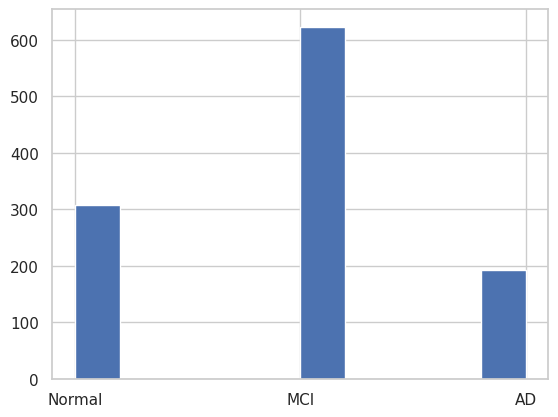

In [82]:
# Create a histogram of the 'AD' column in the dataset_mci_nosmc
dataset_mci_nosmc["AD"].hist()
# The plot is automatically displayed after execution in Colab

In [83]:
# The dataset filtering and creation is now handled in the preprocessing step.
# This cell is no longer needed.

In [84]:
# Print the value counts of the 'AD' column in the dataset_mci_nosmc
print(dataset_mci_nosmc['AD'].value_counts())

AD
MCI       623
Normal    307
AD        192
Name: count, dtype: int64


# **BAR PLOTS**

Text(0, 0.5, 'Frequency')

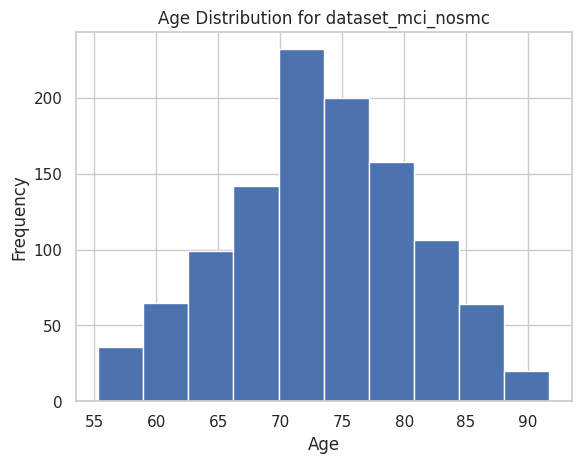

In [85]:
# Create a histogram of the 'true_age' column in dataset_mci_nosmc
dataset_mci_nosmc["true_age"].hist()
plt.title("Age Distribution for dataset_mci_nosmc") # Set the title of the plot
plt.xlabel("Age") # Set the x-axis label
plt.ylabel("Frequency") # Set the y-axis label
# The plot is automatically displayed after execution in Colab

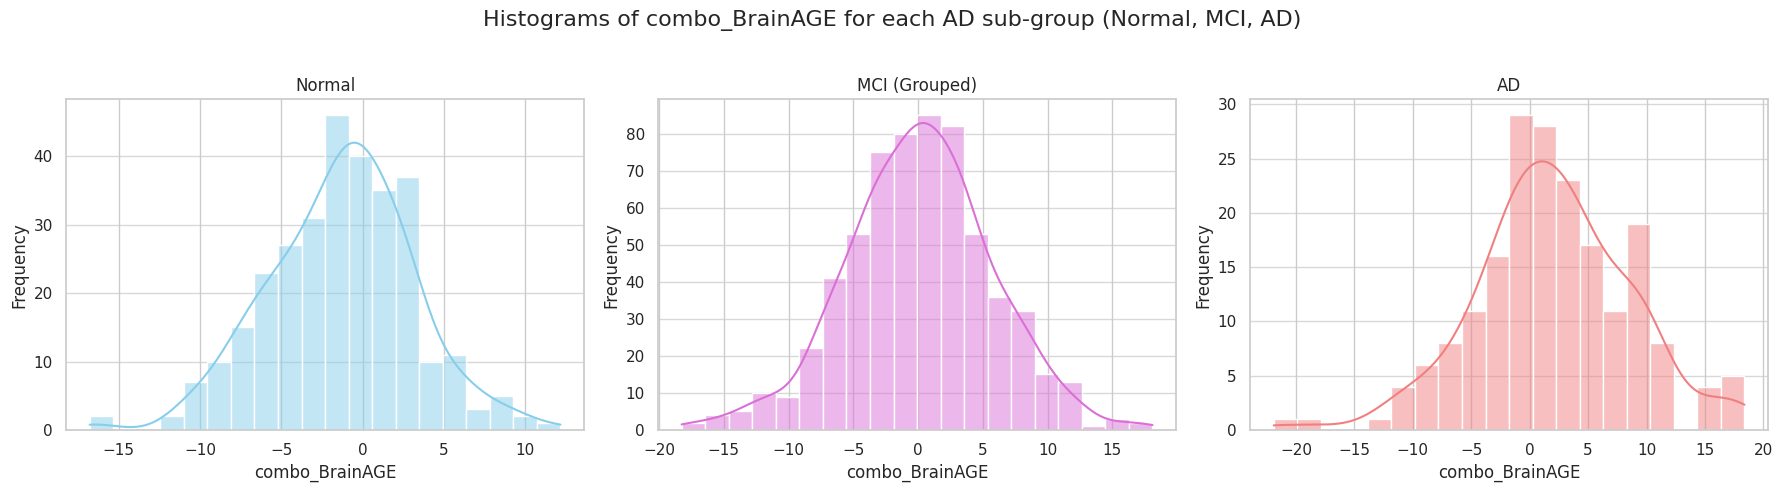

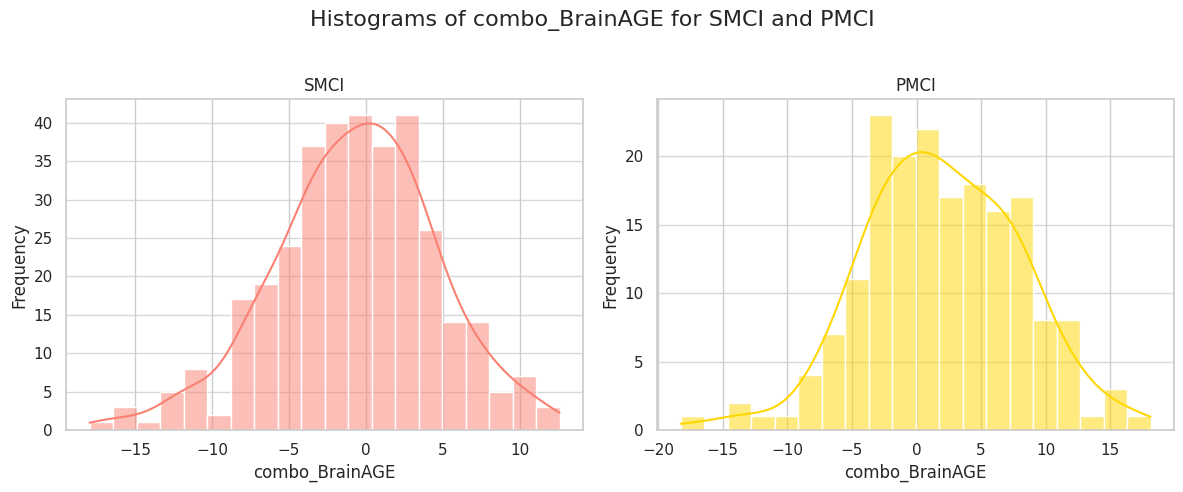

In [86]:
# Create histograms of 'combo_BrainAGE' for each AD sub-group (Normal, MCI, AD) and also for SMCI and PMCI

# Prepare data for plotting by filtering the dataset_mci_nosmc
normalClassData = dataset_mci_nosmc[dataset_mci_nosmc["AD"] == "Normal"]
mciClassData = dataset_mci_nosmc[dataset_mci_nosmc["AD"] == "MCI"]
adClassData = dataset_mci_nosmc[dataset_mci_nosmc["AD"] == "AD"]

# Create a figure and a set of subplots (1 row, 3 columns) for Normal, MCI, and AD
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Histograms of combo_BrainAGE for each AD sub-group (Normal, MCI, AD)', fontsize=16) # Set the main title

# Plot histogram for Normal group
sns.histplot(data=normalClassData, x='combo_BrainAGE', bins=20, color='skyblue', ax=axes[0], kde=True) # Create a histogram with a KDE line
axes[0].set_title('Normal') # Set the subplot title

# Plot histogram for MCI (Grouped)
sns.histplot(data=mciClassData, x='combo_BrainAGE', bins=20, color='orchid', ax=axes[1], kde=True)
axes[1].set_title('MCI (Grouped)')

# Plot histogram for AD
sns.histplot(data=adClassData, x='combo_BrainAGE', bins=20, color='lightcoral', ax=axes[2], kde=True)
axes[2].set_title('AD')

# Set common labels and grid for all subplots
for ax in axes.flat: # Iterate through all axes in the figure
    ax.set(xlabel='combo_BrainAGE', ylabel='Frequency') # Set x and y labels
    ax.grid(axis='y', alpha=0.75) # Add a grid

plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to prevent titles overlapping
plt.show() # Display the plot

# Prepare data for plotting SMCI and PMCI by filtering the dataset_smci_pmci
smciClassData = dataset_smci_pmci[dataset_smci_pmci["AD"] == "SMCI"]
pmciClassData = dataset_smci_pmci[dataset_smci_pmci["AD"] == "PMCI"]

# Create a figure and a set of subplots (1 row, 2 columns) for SMCI and PMCI
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Histograms of combo_BrainAGE for SMCI and PMCI', fontsize=16) # Set the main title

# Plot histogram for SMCI
sns.histplot(data=smciClassData, x='combo_BrainAGE', bins=20, color='salmon', ax=axes[0], kde=True)
axes[0].set_title('SMCI')

# Plot histogram for PMCI
sns.histplot(data=pmciClassData, x='combo_BrainAGE', bins=20, color='gold', ax=axes[1], kde=True)
axes[1].set_title('PMCI')

# Set common labels and grid for all subplots
for ax in axes.flat:
    ax.set(xlabel='combo_BrainAGE', ylabel='Frequency')
    ax.grid(axis='y', alpha=0.75)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show() # Display the plot

Text(0, 0.5, 'Frequency')

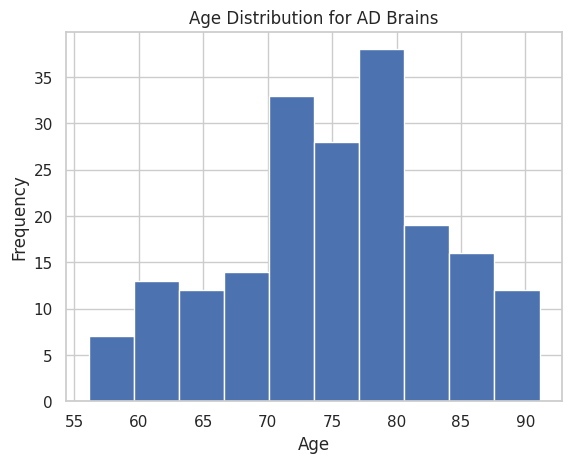

In [87]:
# Create a histogram of 'true_age' for the AD class
adClassData = dataset_mci_nosmc[dataset_mci_nosmc["AD"] == "AD"] # Filter for the AD class
adClassData["true_age"].hist() # Create a histogram of the 'true_age' column
plt.title("Age Distribution for AD Brains") # Set the title of the plot
plt.xlabel("Age") # Set the x-axis label
plt.ylabel("Frequency") # Set the y-axis label
# The plot is automatically displayed after execution in Colab

# **SCATTER PLOTS**

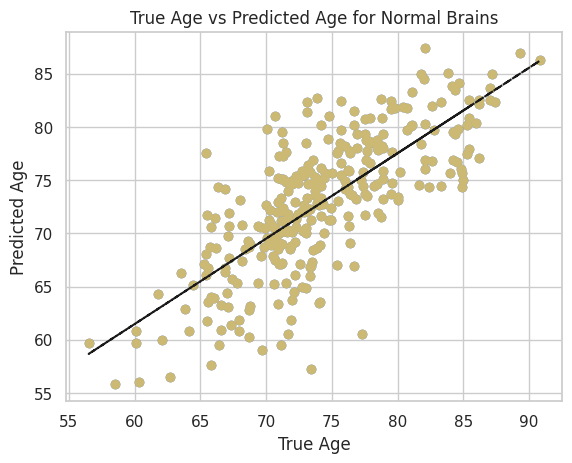

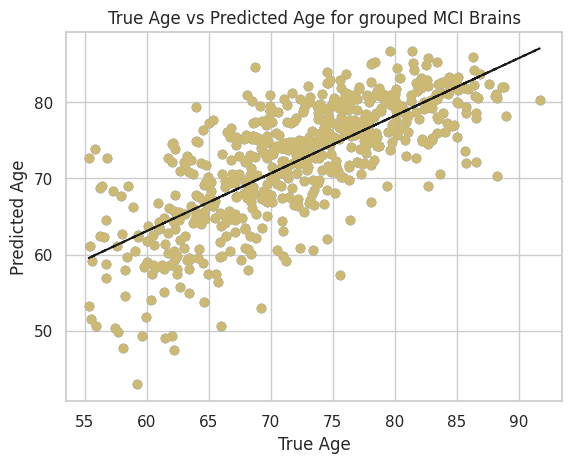

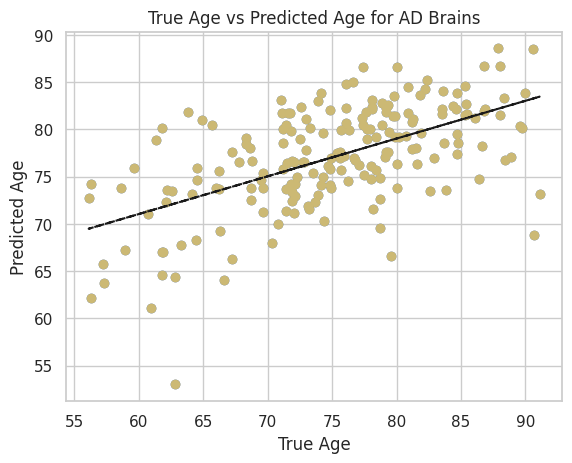

In [88]:
# Create scatter plots of True Age vs. Predicted Age for different AD classes (Normal, MCI, AD)

# Plot for Normal class
normalClassData = dataset_mci_nosmc[dataset_mci_nosmc["AD"] == "Normal"] # Filter for Normal class
normal_x = normalClassData["true_age"] # Extract true age
normal_y = normalClassData["predicted_age_combo"] # Extract predicted age (combo)
plt.figure() # Create a new figure
plt.scatter(normal_x, normal_y) # Create a scatter plot
m, b = np.polyfit(normal_x, normal_y, 1) # Fit a linear regression line (1st degree polynomial)
plt.plot(normal_x, normal_y, 'yo', normal_x, m*(normal_x)+b, '--k') # Plot the data points and the regression line
plt.gca().set_title('True Age vs Predicted Age for Normal Brains') # Set the title of the current axes
plt.xlabel('True Age') # Set the x-axis label
plt.ylabel('Predicted Age') # Set the y-axis label
plt.show() # Display the plot

# Plot for MCI (Grouped) class
mciClassData = dataset_mci_nosmc[dataset_mci_nosmc["AD"] == "MCI"] # Filter for MCI class
mci_x = mciClassData["true_age"] # Extract true age
mci_y = mciClassData["predicted_age_combo"] # Extract predicted age (combo)
plt.figure() # Create a new figure
plt.scatter(mci_x, mci_y) # Create a scatter plot
m, b = np.polyfit(mci_x, mci_y, 1) # Fit a linear regression line
plt.plot(mci_x, mci_y, 'yo', mci_x, m*(mci_x)+b, '--k') # Plot the data points and the regression line
plt.gca().set_title('True Age vs Predicted Age for grouped MCI Brains') # Set the title
plt.xlabel('True Age') # Set x-label
plt.ylabel('Predicted Age') # Set y-label
plt.show() # Display the plot

# Plot for AD class
adClassData = dataset_mci_nosmc[dataset_mci_nosmc["AD"] == "AD"] # Filter for AD class
ad_x = adClassData["true_age"] # Extract true age
ad_y = adClassData["predicted_age_combo"] # Extract predicted age (combo)
plt.figure() # Create a new figure
plt.scatter(ad_x, ad_y) # Create a scatter plot
m, b = np.polyfit(ad_x, ad_y, 1) # Fit a linear regression line
plt.plot(ad_x, ad_y, 'yo', ad_x, m*(ad_x)+b, '--k') # Plot the data points and the regression line
plt.gca().set_title('True Age vs Predicted Age for AD Brains') # Set the title
plt.xlabel('True Age') # Set x-label
plt.ylabel('Predicted Age') # Set y-label
plt.show() # Display the plot

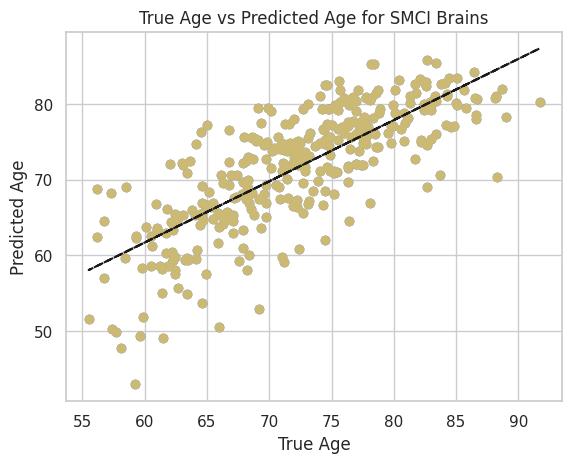

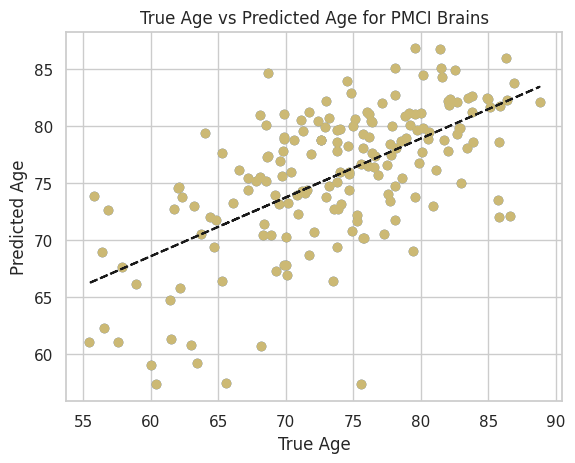

In [89]:
# Create scatter plots of True Age vs. Predicted Age for SMCI and PMCI

# Plot for SMCI class
smciClassData = dataset_smci_pmci[dataset_smci_pmci["AD"] == "SMCI"] # Filter for SMCI class
smci_x = smciClassData["true_age"] # Extract true age
smci_y = smciClassData["predicted_age_combo"] # Extract predicted age (combo)
plt.figure() # Create a new figure
plt.scatter(smci_x, smci_y) # Create a scatter plot
m, b = np.polyfit(smci_x, smci_y, 1) # Fit a linear regression line
plt.plot(smci_x, smci_y, 'yo', smci_x, m*(smci_x)+b, '--k') # Plot the data points and the regression line
plt.gca().set_title('True Age vs Predicted Age for SMCI Brains') # Set the title
plt.xlabel('True Age') # Set x-label
plt.ylabel('Predicted Age') # Set y-label
plt.show() # Display the plot

# Plot for PMCI class
pmciClassData = dataset_smci_pmci[dataset_smci_pmci["AD"] == "PMCI"] # Filter for PMCI class
pmci_x = pmciClassData["true_age"] # Extract true age
pmci_y = pmciClassData["predicted_age_combo"] # Extract predicted age (combo)
plt.figure() # Create a new figure
plt.scatter(pmci_x, pmci_y) # Create a scatter plot
m, b = np.polyfit(pmci_x, pmci_y, 1) # Fit a linear regression line
plt.plot(pmci_x, pmci_y, 'yo', pmci_x, m*(pmci_x)+b, '--k') # Plot the data points and the regression line
plt.gca().set_title('True Age vs Predicted Age for PMCI Brains') # Set the title
plt.xlabel('True Age') # Set x-label
plt.ylabel('Predicted Age') # Set y-label
plt.show() # Display the plot

# **VIOLIN PLRTS**

# **STATISTICAL TESTS**

In [90]:
# Perform Shapiro-Wilk tests for normality on different variables
# The Shapiro-Wilk test tests the null hypothesis that the data was drawn from a normal distribution.
# A small p-value (< 0.05) indicates that the null hypothesis can be rejected, suggesting the data is not normally distributed.

# Shapiro-Wilk test for 'true_age' in dataset_mci_nosmc
stat, p = shapiro(dataset_mci_nosmc["true_age"])
print(f"Shapiro–Wilk test for dataset_mci_nosmc true_age: statistic={stat:.3f}, p-value={p:.3f}" + "\n")

# Shapiro-Wilk test for 'predicted_age_combo' in dataset_mci_nosmc
stat, p = shapiro(dataset_mci_nosmc["predicted_age_combo"])
print(f"Shapiro–Wilk test for dataset_mci_nosmc predicted_age_combo  : statistic={stat:.3f}, p-value={p:.3f}" + "\n")

# Shapiro-Wilk test for 'true_age' in dataset_smci_pmci
stat, p = shapiro(dataset_smci_pmci["true_age"])
print(f"Shapiro–Wilk test for dataset_smci_pmci true_age: statistic={stat:.3f}, p-value={p:.3f}" + "\n")

# Shapiro-Wilk test for 'predicted_age_combo' in dataset_smci_pmci
stat, p = shapiro(dataset_smci_pmci["predicted_age_combo"])
print(f"Shapiro–Wilk test for dataset_smci_pmci predicted_age_combo  : statistic={stat:.3f}, p-value={p:.3f}" + "\n")

Shapiro–Wilk test for dataset_mci_nosmc true_age: statistic=0.994, p-value=0.000

Shapiro–Wilk test for dataset_mci_nosmc predicted_age_combo  : statistic=0.963, p-value=0.000

Shapiro–Wilk test for dataset_smci_pmci true_age: statistic=0.990, p-value=0.001

Shapiro–Wilk test for dataset_smci_pmci predicted_age_combo  : statistic=0.947, p-value=0.000



In [91]:
def compute_effect(control_data, treatment_data):
    """
    Given two arrays of observations, computes:
      - mean_control, mean_treatment
      - sd_control, sd_treatment
      - pooled_sd
      - cohens_d
      - percent_higher (treatment vs. control)
    """
    # Convert input data to numpy arrays for numerical operations
    control = np.asarray(control_data, dtype=float)
    treatment = np.asarray(treatment_data, dtype=float)

    # Calculate basic statistics
    mean_control = control.mean()
    mean_treatment = treatment.mean()
    sd_control = control.std(ddof=1) # Sample standard deviation
    sd_treatment = treatment.std(ddof=1) # Sample standard deviation
    n_control = control.size # Number of observations in control group
    n_treatment = treatment.size # Number of observations in treatment group

    # Calculate pooled standard deviation
    # This is a weighted average of the standard deviations, used for Cohen's d when sample sizes are different
    pooled_sd = np.sqrt(
        ((n_control - 1)*sd_control**2 + (n_treatment - 1)*sd_treatment**2)
        / (n_control + n_treatment - 2)
    )

    # Calculate Cohen's d
    # Cohen's d is a measure of effect size that indicates the standardized difference between two means.
    cohens_d = (mean_treatment - mean_control) / pooled_sd

    # Calculate the percentage difference between the treatment and control means
    percent_higher = ((mean_treatment - mean_control) / mean_control) * 100

    # Return a dictionary containing the computed statistics
    return {
        'mean_control': mean_control,
        'mean_treatment': mean_treatment,
        'sd_control': sd_control,
        'sd_treatment': sd_treatment,
        'pooled_sd': pooled_sd,
        'cohens_d': cohens_d,
        'percent_higher': percent_higher
    }

# Example usage (commented out):
# control_data = [ ... your values ... ]
# treatment_data = [ ... your values ... ]
# results = compute_effect(control_data, treatment_data)
# print(results)

In [92]:
from scipy.stats import kruskal

# Perform Kruskal-Wallis H-test for different scores across AD groups for dataset_mci_nosmc
# The Kruskal-Wallis H-test is a non-parametric test used to compare the means of three or more independent groups.
# It is used here because the Shapiro-Wilk tests indicated that the data is not normally distributed.
print("Kruskal-Wallis H-test for dataset_mci_nosmc:")
# Loop through the BrainAGE score columns
for score in ['t1_BrainAGE', "combo_BrainAGE", "aicbv_BrainAGE"]:
    # Create a list of data for each AD group for the current score
    groups = [dataset_mci_nosmc[dataset_mci_nosmc['AD'] == group][score] for group in dataset_mci_nosmc['AD'].unique()]
    # Perform the Kruskal-Wallis H-test
    stat, p = kruskal(*groups)
    print(f'  Kruskal-Wallis H-test for {score}:')
    print(f'    H-statistic: {stat:.2f}')
    print(f'    p-value: {p:.3f}')
    # Interpret the p-value
    if p < 0.05:
        print("    The differences between the groups are statistically significant.")
    else:
        print("    The differences between the groups are not statistically significant.")
    print() # Add a newline for separation

# Perform Kruskal-Wallis H-test for different scores across AD groups for dataset_smci_pmci
print("Kruskal-Wallis H-test for dataset_smci_pmci:")
# Loop through the BrainAGE score columns
for score in ['t1_BrainAGE', "combo_BrainAGE", "aicbv_BrainAGE"]:
    # Create a list of data for each AD group for the current score
    groups = [dataset_smci_pmci[dataset_smci_pmci['AD'] == group][score] for group in dataset_smci_pmci['AD'].unique()]
    # Perform the Kruskal-Wallis H-test
    stat, p = kruskal(*groups)
    print(f'  Kruskal-Wallis H-test for {score}:')
    print(f'    H-statistic: {stat:.2f}')
    print(f'    p-value: {p:.3f}')
    # Interpret the p-value
    if p < 0.05:
        print("    The differences between the groups are statistically significant.")
    else:
        print("    The differences between the groups are not statistically significant.")
    print() # Add a newline for separation

Kruskal-Wallis H-test for dataset_mci_nosmc:
  Kruskal-Wallis H-test for t1_BrainAGE:
    H-statistic: 30.08
    p-value: 0.000
    The differences between the groups are statistically significant.

  Kruskal-Wallis H-test for combo_BrainAGE:
    H-statistic: 40.82
    p-value: 0.000
    The differences between the groups are statistically significant.

  Kruskal-Wallis H-test for aicbv_BrainAGE:
    H-statistic: 33.63
    p-value: 0.000
    The differences between the groups are statistically significant.

Kruskal-Wallis H-test for dataset_smci_pmci:
  Kruskal-Wallis H-test for t1_BrainAGE:
    H-statistic: 8.35
    p-value: 0.004
    The differences between the groups are statistically significant.

  Kruskal-Wallis H-test for combo_BrainAGE:
    H-statistic: 22.47
    p-value: 0.000
    The differences between the groups are statistically significant.

  Kruskal-Wallis H-test for aicbv_BrainAGE:
    H-statistic: 32.29
    p-value: 0.000
    The differences between the groups are sta

In [93]:
def cohens_d(a, b):
    """
    Calculates Cohen's d effect size for two independent samples.

    Args:
        a (array-like): Data for the first group.
        b (array-like): Data for the second group.

    Returns:
        float: Cohen's d value, or np.nan if the pooled standard deviation is zero.
    """
    # Calculate the pooled standard deviation (assuming equal variances)
    pooled_sd = np.sqrt(((np.asarray(a).std() ** 2) + (np.asarray(b).std() ** 2)) / 2)
    # Calculate Cohen's d
    return (np.asarray(a).mean() - np.asarray(b).mean()) / pooled_sd if pooled_sd else np.nan # Avoid division by zero

# **MATRICES**

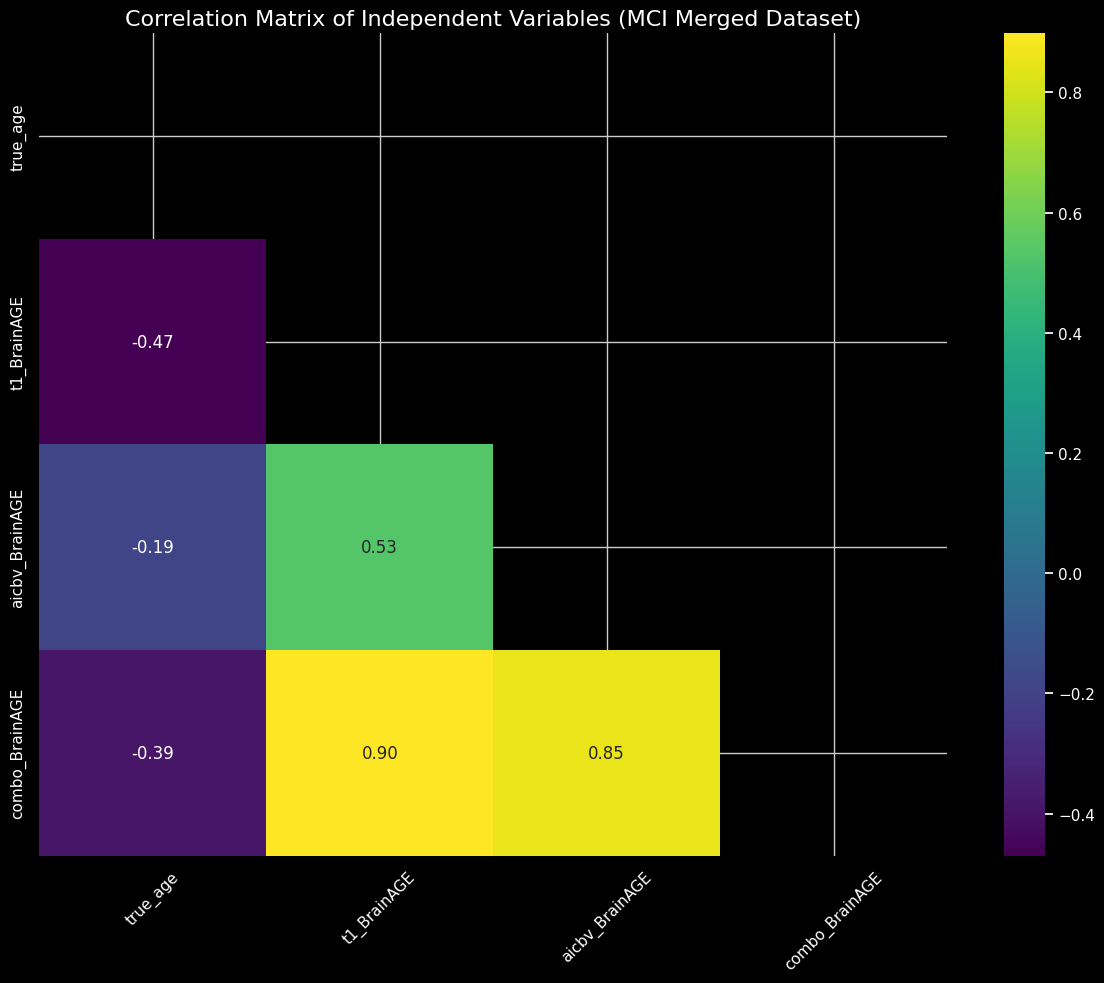

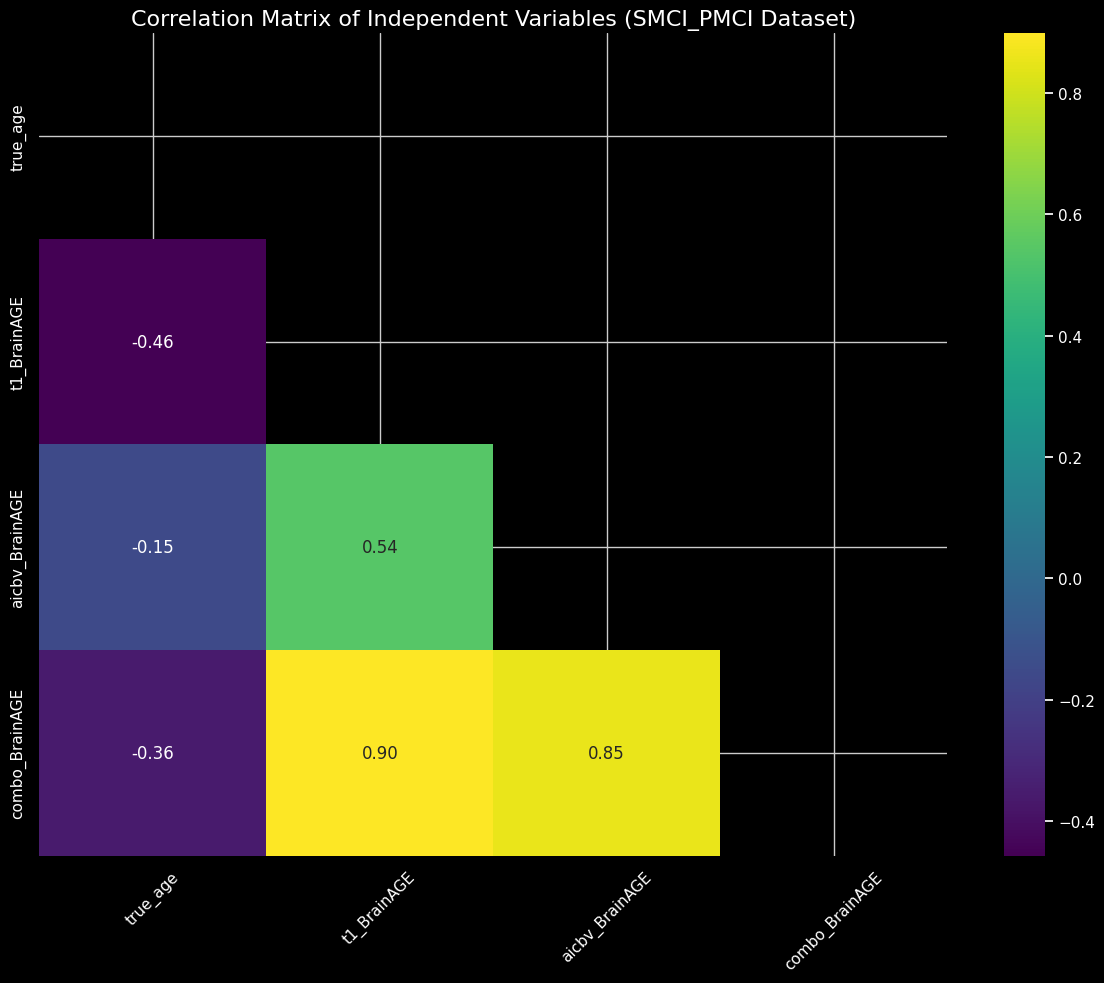

In [94]:
# Create a correlation matrix of independent variables for dataset_mci_nosmc and dataset_smci_pmci

# For dataset_mci_nosmc
# Select the independent variables for the correlation matrix
X_mci = dataset_mci_nosmc[["aicbv_BrainAGE", "t1_BrainAGE", "true_age", "combo_BrainAGE"]] # Removed cognitive variables as per previous code
correlation_matrix_mci = X_mci.corr() # Calculate the pairwise correlation
# Reorder the correlation matrix for better readability
correlation_matrix_mci = correlation_matrix_mci.reindex(index=["true_age", "t1_BrainAGE", "aicbv_BrainAGE", "combo_BrainAGE"], columns=["true_age", "t1_BrainAGE", "aicbv_BrainAGE", "combo_BrainAGE"]) # Ensure consistent order
mask_mci = np.triu(np.ones_like(correlation_matrix_mci, dtype=bool)) # Create a mask for the upper triangle to avoid redundant values

# Create the figure and get the axes for styling
fig_mci = plt.figure(figsize=(12, 10))
ax_mci = plt.gca()

# Create the heatmap of the correlation matrix
sns.heatmap(correlation_matrix_mci, annot=True, mask=mask_mci, cmap='viridis', fmt=".2f", ax=ax_mci)

# --- Style for black background (as seen in previous output) ---
fig_mci.set_facecolor('black')
ax_mci.set_facecolor('black')

# Set title, labels, and ticks to white for visibility against the black background
ax_mci.set_title('Correlation Matrix of Independent Variables (MCI Merged Dataset)', color='white', fontsize=16)
ax_mci.tick_params(axis='x', colors='white', rotation=45) # Rotate x-axis labels for readability
ax_mci.tick_params(axis='y', colors='white')

# Adjust colorbar ticks to be white for visibility
cbar_mci = ax_mci.collections[0].colorbar
cbar_mci.ax.tick_params(colors='white')

plt.tight_layout() # Adjust layout
plt.show() # Display the plot

# For dataset_smci_pmci
# Select the independent variables for the correlation matrix
X_smci = dataset_smci_pmci[["aicbv_BrainAGE", "t1_BrainAGE", "true_age", "combo_BrainAGE"]] # Removed cognitive variables
correlation_matrix_smci = X_smci.corr() # Calculate the pairwise correlation
# Reorder the correlation matrix
correlation_matrix_smci = correlation_matrix_smci.reindex(index=["true_age", "t1_BrainAGE", "aicbv_BrainAGE", "combo_BrainAGE"], columns=["true_age", "t1_BrainAGE", "aicbv_BrainAGE", "combo_BrainAGE"]) # Ensure consistent order
mask_smci = np.triu(np.ones_like(correlation_matrix_smci, dtype=bool)) # Create a mask for the upper triangle

# Create the figure and get the axes for styling
fig_smci = plt.figure(figsize=(12, 10))
ax_smci = plt.gca()

# Create the heatmap of the correlation matrix
sns.heatmap(correlation_matrix_smci, annot=True, mask=mask_smci, cmap='viridis', fmt=".2f", ax=ax_smci)

# --- Style for black background ---
fig_smci.set_facecolor('black')
ax_smci.set_facecolor('black')

# Set title, labels, and ticks to white for visibility
ax_smci.set_title('Correlation Matrix of Independent Variables (SMCI_PMCI Dataset)', color='white', fontsize=16)
ax_smci.tick_params(axis='x', colors='white', rotation=45) # Rotate x-axis labels
ax_smci.tick_params(axis='y', colors='white')

# Adjust colorbar ticks to be white
cbar_smci = ax_smci.collections[0].colorbar
cbar_smci.ax.tick_params(colors='white')

plt.tight_layout() # Adjust layout
plt.show() # Display the plot

In [95]:
# Calculate Cohen's d for combo_BrainAGE between different AD diagnoses for dataset_mci_nosmc and dataset_smci_pmci

# MCI Merged Dataset
diagnoses_mci = dataset_mci_nosmc["AD"].unique() # Get unique diagnoses in the MCI Merged dataset
cohensD_list_combo_mci = [] # List to store Cohen's d results
# Iterate through all combinations of diagnoses
for d1 in diagnoses_mci:
  for d2 in diagnoses_mci:
    if d1 != d2: # Only compare different diagnoses
      group1_brainage = dataset_mci_nosmc[dataset_mci_nosmc["AD"] == d1]["combo_BrainAGE"] # Get combo_BrainAGE for diagnosis d1
      group2_brainage = dataset_mci_nosmc[dataset_mci_nosmc["AD"] == d2]["combo_BrainAGE"] # Get combo_BrainAGE for diagnosis d2
      # Ensure both groups have data and more than one sample before calculating Cohen's d
      if not group1_brainage.empty and not group2_brainage.empty and len(group1_brainage) > 1 and len(group2_brainage) > 1:
        effect_size = cohens_d(group1_brainage, group2_brainage) # Calculate Cohen's d
        cohensD_list_combo_mci.append((d1, d2, effect_size)) # Append the results to the list

cohensD_combo_mci = pd.DataFrame(cohensD_list_combo_mci, columns = ["Diagnosis 1", "Diagnosis 2", "Effect Size"]) # Create a DataFrame from the results list
pivottable_mci = cohensD_combo_mci.pivot(index = "Diagnosis 1", columns = "Diagnosis 2", values = "Effect Size") # Create a pivot table
pivottable_mci = pivottable_mci.fillna(0) # Fill NaN values with 0
pivottable_mci = pivottable_mci.reindex(dataset_mci_nosmc["AD"].cat.categories, axis = 0) # Reindex rows based on ordered categories
pivottable_mci = pivottable_mci.reindex(dataset_mci_nosmc["AD"].cat.categories, axis = 1) # Reindex columns based on ordered categories

# SMCI_PMCI Dataset
diagnoses_smci = dataset_smci_pmci["AD"].unique() # Get unique diagnoses in the SMCI_PMCI dataset
cohensD_list_combo_smci = [] # List to store Cohen's d results
# Iterate through all combinations of diagnoses
for d1 in diagnoses_smci:
    for d2 in diagnoses_smci:
        if d1 != d2: # Only compare different diagnoses
            group1_brainage = dataset_smci_pmci[dataset_smci_pmci["AD"] == d1]["combo_BrainAGE"] # Get combo_BrainAGE for diagnosis d1
            group2_brainage = dataset_smci_pmci[dataset_smci_pmci["AD"] == d2]["combo_BrainAGE"] # Get combo_BrainAGE for diagnosis d2
            # Ensure both groups have data and more than one sample before calculating Cohen's d
            if not group1_brainage.empty and not group2_brainage.empty and len(group1_brainage) > 1 and len(group2_brainage) > 1:
                effect_size = cohens_d(group1_brainage, group2_brainage) # Calculate Cohen's d
                cohensD_list_combo_smci.append((d1, d2, effect_size)) # Append the results to the list

cohensD_combo_smci = pd.DataFrame(cohensD_list_combo_smci, columns = ["Diagnosis 1", "Diagnosis 2", "Effect Size"]) # Create a DataFrame from the results list
pivottable_smci = cohensD_combo_smci.pivot(index = "Diagnosis 1", columns = "Diagnosis 2", values = "Effect Size") # Create a pivot table
pivottable_smci = pivottable_smci.fillna(0) # Fill NaN values with 0
pivottable_smci = pivottable_smci.reindex(dataset_smci_pmci["AD"].cat.categories, axis = 0) # Reindex rows based on ordered categories
pivottable_smci = pivottable_smci.reindex(dataset_smci_pmci["AD"].cat.categories, axis = 1) # Reindex columns based on ordered categories

In [96]:
# Calculate Cohen's d for t1_BrainAGE and aicbv_BrainAGE between different AD diagnoses for dataset_mci_nosmc and dataset_smci_pmci

# t1_BrainAGE - MCI Merged Dataset
diagnoses_mci = dataset_mci_nosmc["AD"].unique() # Get unique diagnoses
cohensD_list_t1_mci = [] # List to store Cohen's d results
# Iterate through combinations of diagnoses
for d1 in diagnoses_mci:
  for d2 in diagnoses_mci:
    if d1 != d2: # Compare different diagnoses
      group1_brainage = dataset_mci_nosmc[dataset_mci_nosmc["AD"] == d1]["t1_BrainAGE"] # Get t1_BrainAGE for diagnosis d1
      group2_brainage = dataset_mci_nosmc[dataset_mci_nosmc["AD"] == d2]["t1_BrainAGE"] # Get t1_BrainAGE for diagnosis d2
      # Ensure sufficient data before calculating Cohen's d
      if not group1_brainage.empty and not group2_brainage.empty and len(group1_brainage) > 1 and len(group2_brainage) > 1:
        effect_size = cohens_d(group1_brainage, group2_brainage) # Calculate Cohen's d
        cohensD_list_t1_mci.append((d1, d2, effect_size)) # Append results

cohensD_t1_mci = pd.DataFrame(cohensD_list_t1_mci, columns = ["Diagnosis 1", "Diagnosis 2", "Effect Size"]) # Create DataFrame
pivottable_mci_t1 = cohensD_t1_mci.pivot(index = "Diagnosis 1", columns = "Diagnosis 2", values = "Effect Size") # Create pivot table
pivottable_mci_t1 = pivottable_mci_t1.fillna(0) # Fill NaN with 0
pivottable_mci_t1 = pivottable_mci_t1.reindex(dataset_mci_nosmc["AD"].cat.categories, axis = 0) # Reindex rows
pivottable_mci_t1 = pivottable_mci_t1.reindex(dataset_mci_nosmc["AD"].cat.categories, axis = 1) # Reindex columns

# t1_BrainAGE - SMCI_PMCI Dataset
diagnoses_smci = dataset_smci_pmci["AD"].unique() # Get unique diagnoses
cohensD_list_t1_smci = [] # List to store Cohen's d results
# Iterate through combinations of diagnoses
for d1 in diagnoses_smci:
    for d2 in diagnoses_smci:
        if d1 != d2: # Compare different diagnoses
            group1_brainage = dataset_smci_pmci[dataset_smci_pmci["AD"] == d1]["t1_BrainAGE"] # Get t1_BrainAGE for diagnosis d1
            group2_brainage = dataset_smci_pmci[dataset_smci_pmci["AD"] == d2]["t1_BrainAGE"] # Get t1_BrainAGE for diagnosis d2
            # Ensure sufficient data before calculating Cohen's d
            if not group1_brainage.empty and not group2_brainage.empty and len(group1_brainage) > 1 and len(group2_brainage) > 1:
                effect_size = cohens_d(group1_brainage, group2_brainage) # Calculate Cohen's d
                cohensD_list_t1_smci.append((d1, d2, effect_size)) # Append results

cohensD_t1_smci = pd.DataFrame(cohensD_list_t1_smci, columns = ["Diagnosis 1", "Diagnosis 2", "Effect Size"]) # Create DataFrame
pivottable_smci_t1 = cohensD_t1_smci.pivot(index = "Diagnosis 1", columns = "Diagnosis 2", values = "Effect Size") # Create pivot table
pivottable_smci_t1 = pivottable_smci_t1.fillna(0) # Fill NaN with 0
pivottable_smci_t1 = pivottable_smci_t1.reindex(dataset_smci_pmci["AD"].cat.categories, axis = 0) # Reindex rows
pivottable_smci_t1 = pivottable_smci_t1.reindex(dataset_smci_pmci["AD"].cat.categories, axis = 1) # Reindex columns

# aicbv_BrainAGE - MCI Merged Dataset
diagnoses_mci = dataset_mci_nosmc["AD"].unique() # Get unique diagnoses
cohensD_list_aicbv_mci = [] # List to store Cohen's d results
# Iterate through combinations of diagnoses
for d1 in diagnoses_mci:
  for d2 in diagnoses_mci:
    if d1 != d2: # Compare different diagnoses
      group1_brainage = dataset_mci_nosmc[dataset_mci_nosmc["AD"] == d1]["aicbv_BrainAGE"] # Get aicbv_BrainAGE for diagnosis d1
      group2_brainage = dataset_mci_nosmc[dataset_mci_nosmc["AD"] == d2]["aicbv_BrainAGE"] # Get aicbv_BrainAGE for diagnosis d2
      # Ensure sufficient data before calculating Cohen's d
      if not group1_brainage.empty and not group2_brainage.empty and len(group1_brainage) > 1 and len(group2_brainage) > 1:
        effect_size = cohens_d(group1_brainage, group2_brainage) # Calculate Cohen's d
        cohensD_list_aicbv_mci.append((d1, d2, effect_size)) # Append results

cohensD_aicbv_mci = pd.DataFrame(cohensD_list_aicbv_mci, columns = ["Diagnosis 1", "Diagnosis 2", "Effect Size"]) # Create DataFrame
pivottable_mci_aicbv = cohensD_aicbv_mci.pivot(index = "Diagnosis 1", columns = "Diagnosis 2", values = "Effect Size") # Create pivot table
pivottable_mci_aicbv = pivottable_mci_aicbv.fillna(0) # Fill NaN with 0
pivottable_mci_aicbv = pivottable_mci_aicbv.reindex(dataset_mci_nosmc["AD"].cat.categories, axis = 0) # Reindex rows
pivottable_mci_aicbv = pivottable_mci_aicbv.reindex(dataset_mci_nosmc["AD"].cat.categories, axis = 1) # Reindex columns

# aicbv_BrainAGE - SMCI_PMCI Dataset
diagnoses_smci = dataset_smci_pmci["AD"].unique() # Get unique diagnoses
cohensD_list_aicbv_smci = [] # List to store Cohen's d results
# Iterate through combinations of diagnoses
for d1 in diagnoses_smci:
    for d2 in diagnoses_smci:
        if d1 != d2: # Compare different diagnoses
            group1_brainage = dataset_smci_pmci[dataset_smci_pmci["AD"] == d1]["aicbv_BrainAGE"] # Get aicbv_BrainAGE for diagnosis d1
            group2_brainage = dataset_smci_pmci[dataset_smci_pmci["AD"] == d2]["aicbv_BrainAGE"] # Get aicbv_BrainAGE for diagnosis d2
            # Ensure sufficient data before calculating Cohen's d
            if not group1_brainage.empty and not group2_brainage.empty and len(group1_brainage) > 1 and len(group2_brainage) > 1:
                effect_size = cohens_d(group1_brainage, group2_brainage) # Calculate Cohen's d
                cohensD_list_aicbv_smci.append((d1, d2, effect_size)) # Append results

cohensD_aicbv_smci = pd.DataFrame(cohensD_list_aicbv_smci, columns = ["Diagnosis 1", "Diagnosis 2", "Effect Size"]) # Create DataFrame
pivottable_smci_aicbv = cohensD_aicbv_smci.pivot(index = "Diagnosis 1", columns = "Diagnosis 2", values = "Effect Size") # Create pivot table
pivottable_smci_aicbv = pivottable_smci_aicbv.fillna(0) # Fill NaN with 0
pivottable_smci_aicbv = pivottable_smci_aicbv.reindex(dataset_smci_pmci["AD"].cat.categories, axis = 0) # Reindex rows
pivottable_smci_aicbv = pivottable_smci_aicbv.reindex(dataset_smci_pmci["AD"].cat.categories, axis = 1) # Reindex columns

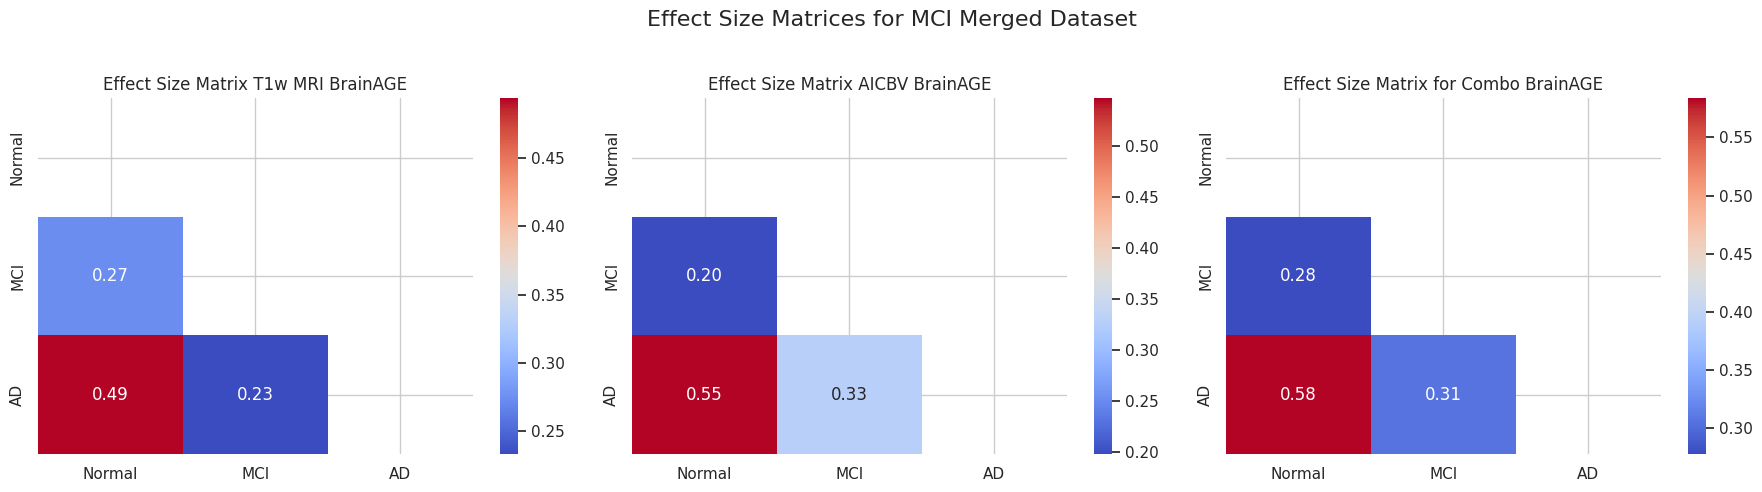

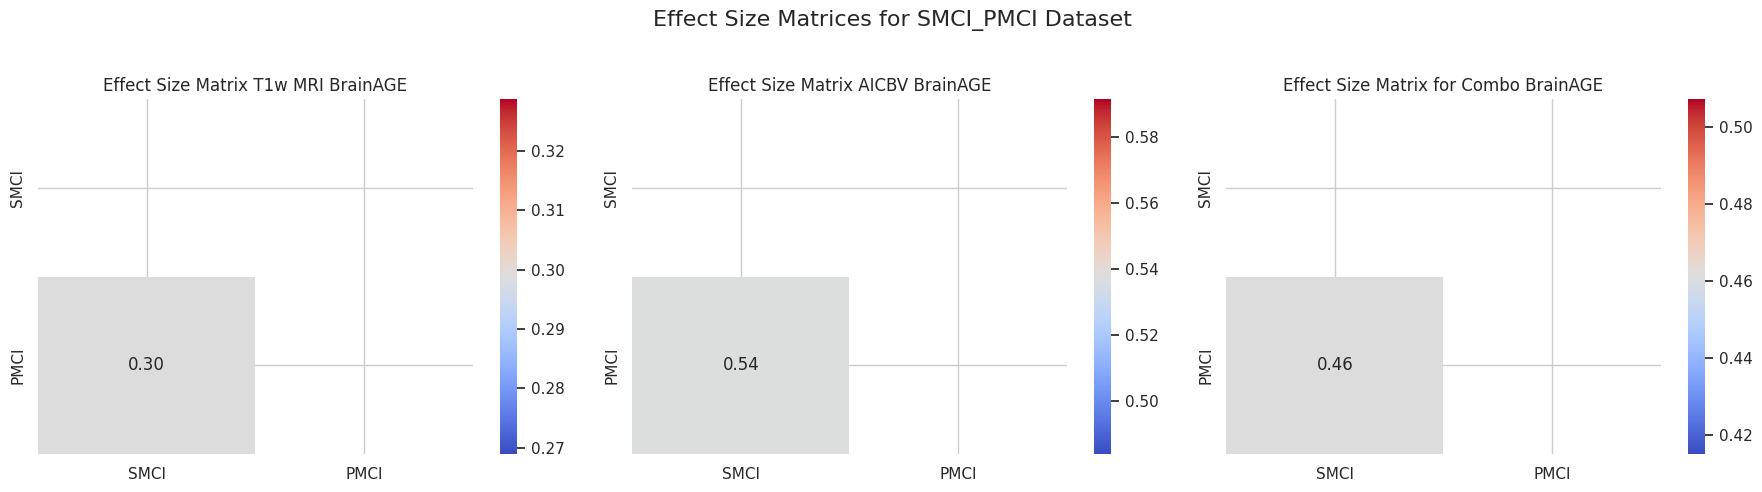

In [97]:
# Create heatmaps of the effect size matrices for dataset_mci_nosmc and dataset_smci_pmci

# MCI Merged Dataset
# Create a figure and a set of subplots (1 row, 3 columns) for the heatmaps
fig_mci, axes_mci = plt.subplots(1, 3, figsize=(18, 5))
fig_mci.suptitle('Effect Size Matrices for MCI Merged Dataset', fontsize=16) # Set the main title

# Plot heatmap for t1_BrainAGE - MCI Merged
mask_mci_t1 = np.triu(np.ones_like(pivottable_mci_t1, dtype=bool)) # Mask the upper triangle
sns.heatmap(pivottable_mci_t1.astype(float), mask=mask_mci_t1, annot=True, cmap='coolwarm', fmt=".2f", ax=axes_mci[0], linewidths=0) # Create the heatmap
axes_mci[0].set_title('Effect Size Matrix T1w MRI BrainAGE') # Set the subplot title

# Plot heatmap for aicbv_BrainAGE - MCI Merged
mask_mci_aicbv = np.triu(np.ones_like(pivottable_mci_aicbv, dtype=bool)) # Mask the upper triangle
sns.heatmap(pivottable_mci_aicbv.astype(float), mask=mask_mci_aicbv, annot=True, cmap='coolwarm', fmt=".2f", ax=axes_mci[1], linewidths=0) # Create the heatmap
axes_mci[1].set_title('Effect Size Matrix AICBV BrainAGE') # Set the subplot title

# Plot heatmap for combo_BrainAGE - MCI Merged
mask_mci_combo = np.triu(np.ones_like(pivottable_mci, dtype=bool)) # Mask the upper triangle
sns.heatmap(pivottable_mci.astype(float), mask=mask_mci_combo, annot=True, cmap='coolwarm', fmt=".2f", ax=axes_mci[2], linewidths=0) # Create the heatmap
axes_mci[2].set_title('Effect Size Matrix for Combo BrainAGE') # Set the subplot title

plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout
plt.show() # Display the plots

# SMCI_PMCI Dataset
# Create a figure and a set of subplots (1 row, 3 columns) for the heatmaps
fig_smci, axes_smci = plt.subplots(1, 3, figsize=(18, 5))
fig_smci.suptitle('Effect Size Matrices for SMCI_PMCI Dataset', fontsize=16) # Set the main title

# Plot heatmap for t1_BrainAGE - SMCI_PMCI
mask_smci_t1 = np.triu(np.ones_like(pivottable_smci_t1, dtype=bool)) # Mask the upper triangle
sns.heatmap(pivottable_smci_t1.astype(float), mask=mask_smci_t1, annot=True, cmap='coolwarm', fmt=".2f", ax=axes_smci[0], linewidths=0) # Create the heatmap
axes_smci[0].set_title('Effect Size Matrix T1w MRI BrainAGE') # Set the subplot title

# Plot heatmap for aicbv_BrainAGE - SMCI_PMCI
mask_smci_aicbv = np.triu(np.ones_like(pivottable_smci_aicbv, dtype=bool)) # Mask the upper triangle
sns.heatmap(pivottable_smci_aicbv.astype(float), mask=mask_smci_aicbv, annot=True, cmap='coolwarm', fmt=".2f", ax=axes_smci[1], linewidths=0) # Create the heatmap
axes_smci[1].set_title('Effect Size Matrix AICBV BrainAGE') # Set the subplot title

# Plot heatmap for combo_BrainAGE - SMCI_PMCI
mask_smci_combo = np.triu(np.ones_like(pivottable_smci, dtype=bool)) # Mask the upper triangle
sns.heatmap(pivottable_smci.astype(float), mask=mask_smci_combo, annot=True, cmap='coolwarm', fmt=".2f", ax=axes_smci[2], linewidths=0) # Create the heatmap
axes_smci[2].set_title('Effect Size Matrix for Combo BrainAGE') # Set the subplot title

plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout
plt.show() # Display the plots

In [98]:
# Compute the effect size (Cohen's d) of true age between males and females for dataset_mci_nosmc and dataset_smci_pmci

print("Cohen's d for true_age between males and females (MCI Merged Dataset):")
# Use the compute_effect function to calculate various statistics including Cohen's d
computed_results_mci = compute_effect(dataset_mci_nosmc[dataset_mci_nosmc["Sex"] == "M"]["true_age"], dataset_mci_nosmc[dataset_mci_nosmc["Sex"] == "F"]["true_age"])
print(computed_results_mci) # Print the results dictionary

print("\nCohen's d for true_age between males and females (SMCI_PMCI Dataset):")
# Use the compute_effect function to calculate various statistics including Cohen's d
computed_results_smci = compute_effect(dataset_smci_pmci[dataset_smci_pmci["Sex"] == "M"]["true_age"], dataset_smci_pmci[dataset_smci_pmci["Sex"] == "F"]["true_age"])
print(computed_results_smci) # Print the results dictionary

Cohen's d for true_age between males and females (MCI Merged Dataset):
{'mean_control': np.float64(74.37289048473967), 'mean_treatment': np.float64(72.28098159509202), 'sd_control': np.float64(7.223398312209687), 'sd_treatment': np.float64(7.350718311174381), 'pooled_sd': np.float64(7.283188915632958), 'cohens_d': np.float64(-0.2872243070830539), 'percent_higher': np.float64(-2.8127303860495876)}

Cohen's d for true_age between males and females (SMCI_PMCI Dataset):
{'mean_control': np.float64(73.82372881355933), 'mean_treatment': np.float64(71.67739130434784), 'sd_control': np.float64(7.182682759727596), 'sd_treatment': np.float64(7.892592966362522), 'pooled_sd': np.float64(7.501795366128887), 'cohens_d': np.float64(-0.2861098449715585), 'percent_higher': np.float64(-2.9073816016961613)}


# BrainAGE Clinical Relevance Analysis

In [99]:
def cohens_d_matrix(dataset, group_col, value_col):
    """
    Calculates a matrix of Cohen's d effect sizes between all pairs of groups in a dataset.

    Args:
        dataset (pd.DataFrame): The input DataFrame.
        group_col (str): The name of the column containing the group labels.
        value_col (str): The name of the column containing the values for which to calculate effect size.

    Returns:
        pd.DataFrame: A matrix of Cohen's d values.
    """
    # Get unique group levels, handling categorical data
    levels = dataset[group_col].dropna().unique()
    levels = list(dataset[group_col].cat.categories) if hasattr(dataset[group_col], "cat") else sorted(levels)
    # Initialize an empty DataFrame to store the Cohen's d matrix
    d_matrix = pd.DataFrame(index=levels, columns=levels, dtype=float)

    # Iterate through all combinations of group pairs
    for a, b in combinations(levels, 2):
        # Extract values for each group, dropping NaN values
        a_vals = dataset[dataset[group_col] == a][value_col].dropna()
        b_vals = dataset[dataset[group_col] == b][value_col].dropna()
        # Calculate Cohen's d between the two groups
        d = cohens_d(a_vals, b_vals)
        # Store the Cohen's d value in the matrix (symmetric)
        d_matrix.loc[a, b] = d
        d_matrix.loc[b, a] = -d # Cohen's d is symmetric with opposite sign

    np.fill_diagonal(d_matrix.values, 0) # Fill the diagonal with 0 (effect size of a group with itself is 0)
    return d_matrix # Return the completed Cohen's d matrix

def plot_effect_size_heatmap(d_matrix, title):
    """
    Plots a heatmap of the Cohen's d effect size matrix.

    Args:
        d_matrix (pd.DataFrame): The Cohen's d matrix.
        title (str): The title for the heatmap.
    """
    plt.figure(figsize=(8, 6)) # Create a new figure
    # Create a heatmap using seaborn
    sns.heatmap(d_matrix.astype(float), annot=True, fmt=".2f", center=0, cmap="vlag", linewidths=0.5, cbar_kws={'label': "Cohen's d"})
    plt.title(title) # Set the title
    plt.yticks(rotation=0) # Prevent y-axis labels from rotating
    plt.xticks(rotation=45) # Rotate x-axis labels for readability
    plt.tight_layout() # Adjust layout
    plt.show() # Display the plot

# Loop through BrainAGE types and display effect size heatmaps
def plot_all_brainage_effect_sizes(dataset, group_col='AD'):
    """
    Plots effect size heatmaps for different BrainAGE measures across specified groups.

    Args:
        dataset (pd.DataFrame): The input DataFrame.
        group_col (str, optional): The column to use for grouping. Defaults to 'AD'.
    """
    brainage_cols = ['t1_BrainAGE', 'aicbv_BrainAGE', 'combo_BrainAGE'] # List of BrainAGE columns

    # Iterate through each BrainAGE column
    for col in brainage_cols:
        # Create a subset of the dataset with the group column and the current BrainAGE column, dropping NaNs
        sub_dataset = dataset[dataset[group_col].notna()][[group_col, col]].dropna() # Ensure group_col is not NaN before dropping
        # Check if there is more than one unique group to compare
        if len(sub_dataset[group_col].dropna().unique()) > 1:
            d_matrix = cohens_d_matrix(sub_dataset, group_col, col) # Calculate the Cohen's d matrix
            plot_effect_size_heatmap(d_matrix, title=f"Cohen's d Heatmap: {col} by {group_col}") # Plot the heatmap
        else:
            print(f"Not enough groups to plot {col} by {group_col}") # Print a message if there's only one group


def p_print(p_value, threshold=0.05):
    """
    Formats a p-value for printing with color coding based on a significance threshold.

    Args:
        p_value (float): The p-value to format.
        threshold (float, optional): The significance threshold. Defaults to 0.05.

    Returns:
        str: The formatted p-value with color coding.
    """
    # Define ANSI color codes
    GREEN = "\033[92m"
    RED = "\033[91m"
    RESET = "\033[0m"

    # Apply color based on the p-value and threshold
    color = GREEN if p_value < threshold else RED
    return f"{color}p = {p_value:.3e}{RESET}" # Return the formatted string

In [100]:
# Print the number of rows in the dataset where the 'AD' column is 'MCI'
print(len(dataset[dataset['AD'] == "MCI"]))

49


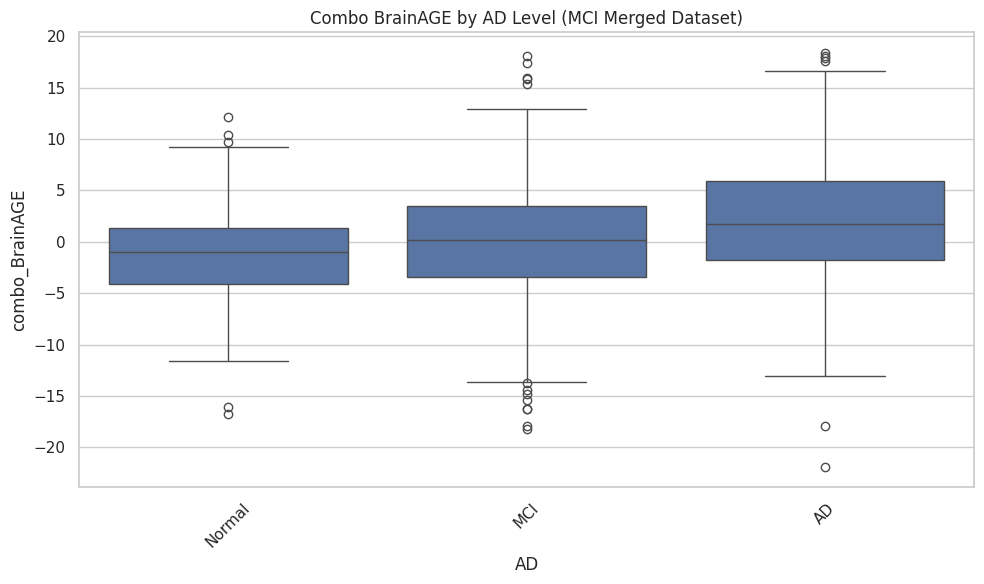

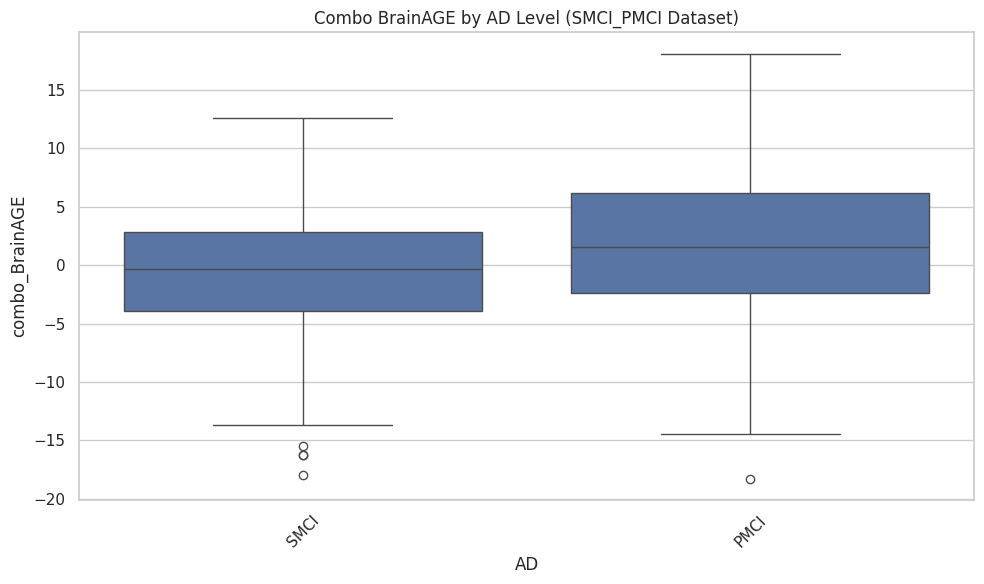

In [101]:
# Create boxplots of 'combo_BrainAGE' by AD level for dataset_mci_nosmc and dataset_smci_pmci

# Boxplot for dataset_mci_nosmc
plt.figure(figsize=(10, 6)) # Create a new figure
sns.set(style="whitegrid") # Set the plot style
# Create a boxplot, filtering out rows with NaN in 'AD', 'combo_BrainAGE', or 'Sex'
sns.boxplot(x="AD", y="combo_BrainAGE", data=dataset_mci_nosmc[dataset_mci_nosmc['AD'].notna()])
plt.title("Combo BrainAGE by AD Level (MCI Merged Dataset)") # Set the title
plt.xticks(rotation=45) # Rotate x-axis labels
plt.tight_layout() # Adjust layout
plt.show() # Display the plot

# Boxplot for dataset_smci_pmci
plt.figure(figsize=(10, 6)) # Create a new figure
sns.set(style="whitegrid") # Set the plot style
# Create a boxplot, filtering out rows with NaN in 'AD', 'combo_BrainAGE', or 'Sex'
sns.boxplot(x="AD", y="combo_BrainAGE", data=dataset_smci_pmci[dataset_smci_pmci['AD'].notna()])
plt.title("Combo BrainAGE by AD Level (SMCI_PMCI Dataset)") # Set the title
plt.xticks(rotation=45) # Rotate x-axis labels
plt.tight_layout() # Adjust layout
plt.show() # Display the plot

In [102]:
# Perform Kruskal-Wallis H-tests for different BrainAGE measures across AD groups
# and print the results with color-coded p-values.

datasets_for_analysis = ['MCI Merged', 'SMCI_PMCI'] # List of dataset keys to analyze

# Loop through the specified dataframes stored in the dataset_ls dictionary
for key in datasets_for_analysis:
    dataset = dataset_ls[key] # Get the current dataset
    print(f"Using {key}...") # Print the name of the dataset being used
    # Create a clean subset of the data, keeping only 'AD' and BrainAGE columns, and dropping rows with NaNs
    ad_clean = dataset[dataset['AD'].notna()][['AD', 't1_BrainAGE', 'aicbv_BrainAGE', 'combo_BrainAGE']].dropna()
    # Loop through each BrainAGE column
    for col in ['t1_BrainAGE', 'aicbv_BrainAGE', 'combo_BrainAGE']:
        # Group the data by 'AD' and apply the list function to get a list of values for each group
        groups = ad_clean.groupby('AD')[col].apply(list)
        # Check if there is more than one group to compare for the current BrainAGE measure
        if len(groups) > 1:
            stat, p = kruskal(*groups) # Perform the Kruskal-Wallis H-test
            print(f"Kruskal-Wallis for {col}: H = {stat:.2f}, {p_print(p)}") # Print the results with formatted p-value
        else:
            print(f"Kruskal-Wallis for {col}: Only one group present.") # Indicate if there's only one group
    print("---") # Print a separator line

Using MCI Merged...
Kruskal-Wallis for t1_BrainAGE: H = 30.08, p = 2.943e-07
Kruskal-Wallis for aicbv_BrainAGE: H = 33.63, p = 4.982e-08
Kruskal-Wallis for combo_BrainAGE: H = 40.82, p = 1.369e-09
---
Using SMCI_PMCI...
Kruskal-Wallis for t1_BrainAGE: H = 8.35, p = 3.855e-03
Kruskal-Wallis for aicbv_BrainAGE: H = 32.29, p = 1.326e-08
Kruskal-Wallis for combo_BrainAGE: H = 22.47, p = 2.131e-06
---


In [103]:
def display_kruskal_wallis_combined_table(dataset_ls):
    """
    Performs Kruskal-Wallis tests for specified BrainAGE measures across AD groups
    in multiple datasets and displays the results in formatted tables.

    Args:
        dataset_ls (dict): A dictionary where keys are dataset names and values are DataFrames.
    """
    # Mapping of internal column names to display names for BrainAGE types
    brainage_cols_mapping = {
        't1_BrainAGE': 'T1 BrainAGE',
        'aicbv_BrainAGE': 'AICBV BrainAGE',
        'combo_BrainAGE': 'Combo BrainAGE'
    }
    # List of dataset keys to include in the combined table display
    datasets_to_display = ['MCI Merged', 'SMCI_PMCI']
    # Mapping of dataset keys to desired table titles
    table_names = {
        'MCI Merged': "Kruskal-Wallis Tests for Normal, MCI, and AD",
        'SMCI_PMCI': "Kruskal-Wallis Tests for SMCI and PMCI"
    }
    all_results = [] # List to store results from all tests

    # Iterate through the BrainAGE columns
    for original_col, display_col in brainage_cols_mapping.items():
        results = {} # Dictionary to store results for the current BrainAGE type across datasets
        # Iterate through the specified datasets
        for key in datasets_to_display:
            dataset = dataset_ls[key] # Get the current dataset
            # Create a clean subset with 'AD' and the current BrainAGE column, dropping NaNs
            ad_clean = dataset[dataset['AD'].notna()][[
                'AD', original_col
            ]].dropna()
            # Check if there is more than one group to compare
            if len(ad_clean['AD'].dropna().unique()) > 1:
                groups = ad_clean.groupby('AD')[original_col].apply(list) # Group data by 'AD'
                stat, p = kruskal(*groups) # Perform Kruskal-Wallis test
                results[key] = {'H Statistic': stat, 'p-value': p} # Store results
            else:
                results[key] = {'H Statistic': np.nan, 'p-value': np.nan} # Store NaN if only one group

        results_dataset = pd.DataFrame.from_dict(results, orient='index') # Create a DataFrame from the results
        if not results_dataset.empty: # Check if the results DataFrame is not empty
            results_dataset['BrainAGE Type'] = display_col # Add a column for the BrainAGE display name
            results_dataset['Dataset'] = results_dataset.index # Add a column for the dataset key
            all_results.append(results_dataset) # Append the results DataFrame to the list

    if all_results: # Check if there are any results to display
        combined_results_dataset = pd.concat(all_results) # Concatenate all results DataFrames

        # Iterate through the datasets to display and print formatted tables
        for dataset_key in datasets_to_display:
            # Filter results for the current dataset and set 'BrainAGE Type' as index
            dataset_results_dataset = combined_results_dataset[combined_results_dataset['Dataset'] == dataset_key].set_index('BrainAGE Type').drop(columns='Dataset')

            print(table_names[dataset_key]) # Print the table title
            # Apply formatting and color mapping for display
            styled_table = dataset_results_dataset.style.format({
                'p-value': '{:.3e}', # Format p-value in scientific notation
                'H Statistic': '{:.3f}' # Format H statistic to 3 decimal places
            }).applymap(
                lambda x: 'background-color: #228B2280;' if not np.isnan(x) and x < 0.05 else '', # Muted forest green background for significant p-values
                subset=['p-value'] # Apply formatting only to the 'p-value' column
            )
            display(styled_table) # Display the styled table
            print("\n") # Add a newline for separation

    else:
        print("No results to display.") # Print a message if there are no results

# Call the function to display the combined Kruskal-Wallis test tables
display_kruskal_wallis_combined_table(dataset_ls)

Kruskal-Wallis Tests for Normal, MCI, and AD


,H Statistic,p-value
BrainAGE Type,,
T1 BrainAGE,30.078,2.943e-07
AICBV BrainAGE,33.630,4.982e-08
Combo BrainAGE,40.819,1.369e-09




Kruskal-Wallis Tests for SMCI and PMCI


,H Statistic,p-value
BrainAGE Type,,
T1 BrainAGE,8.351,3.855e-03
AICBV BrainAGE,32.292,1.326e-08
Combo BrainAGE,22.473,2.131e-06


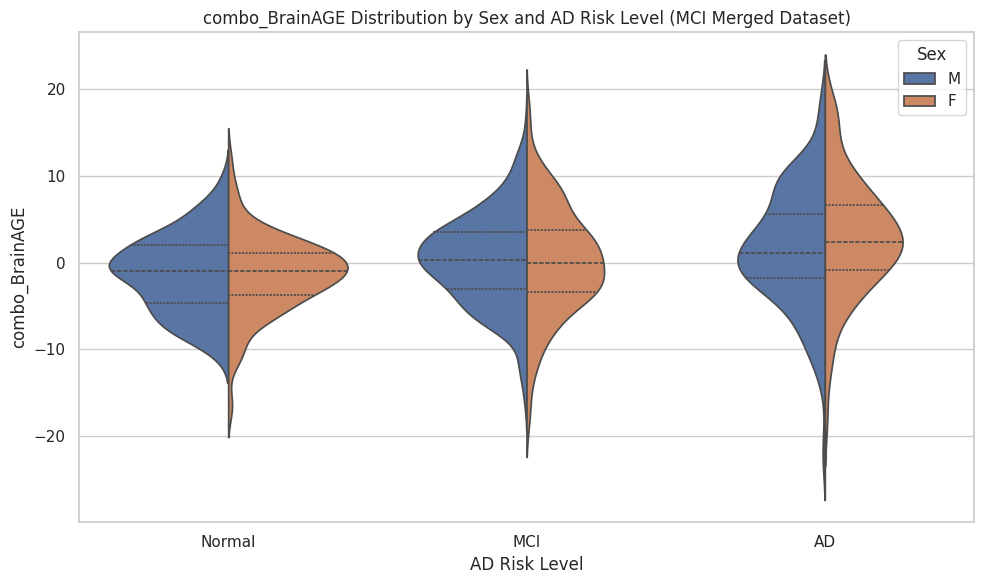

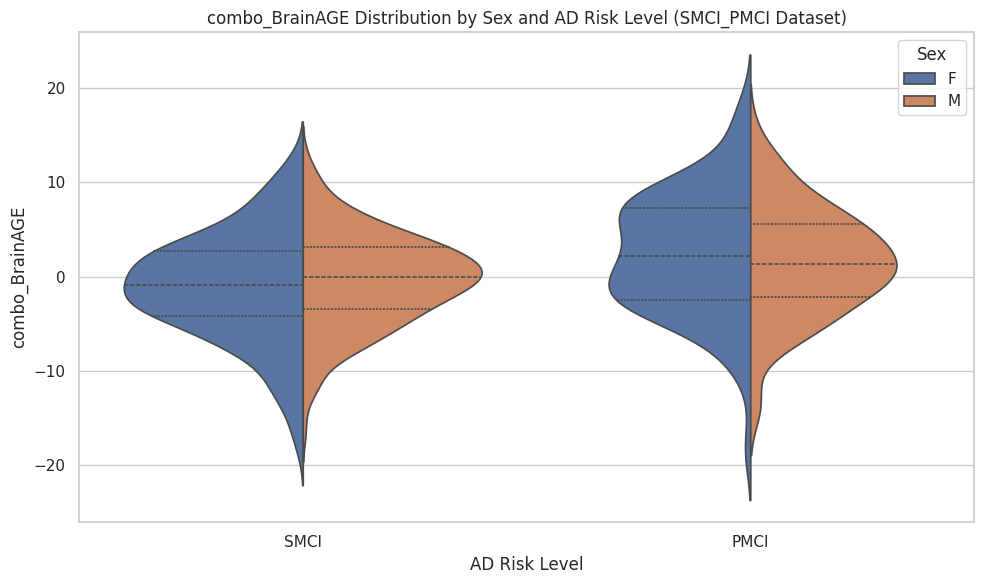

In [104]:
plt.figure(figsize=(10, 6)) # Create a new figure
sns.set(style="whitegrid") # Set the plot style

# Filter out rows where 'Sex' is 'X' and drop NaNs for plotting MCI Merged dataset
plot_data_mci = dataset_ls['MCI Merged'].dropna(subset=['AD','combo_BrainAGE','Sex'])
plot_data_mci = plot_data_mci[plot_data_mci['Sex'] != 'X']

# Create a violin plot for combo_BrainAGE distribution by Sex and AD Risk Level (MCI Merged)
sns.violinplot(
    x='AD', # Column for x-axis (AD Risk Level)
    y='combo_BrainAGE', # Column for y-axis (combo_BrainAGE)
    hue='Sex', # Column for creating split violins based on Sex
    data = plot_data_mci, # Use the filtered data
    split=True, # Split violins for each sex
    inner='quartile', # Show quartiles inside the violins
    order = ["Normal", "MCI", "AD"] # Specify the order of AD levels on the x-axis
)

plt.title('combo_BrainAGE Distribution by Sex and AD Risk Level (MCI Merged Dataset)') # Set the title
plt.xlabel('AD Risk Level') # Set the x-axis label
plt.ylabel('combo_BrainAGE') # Set the y-axis label
plt.legend(title='Sex') # Add a legend for Sex
plt.tight_layout() # Adjust layout
plt.show() # Display the plot

plt.figure(figsize=(10, 6)) # Create a new figure
sns.set(style="whitegrid") # Set the plot style

# Filter out rows where 'Sex' is 'X' and drop NaNs for plotting SMCI_PMCI dataset
plot_data_smci = dataset_ls['SMCI_PMCI'].dropna(subset=['AD','combo_BrainAGE','Sex'])
plot_data_smci = plot_data_smci[plot_data_smci['Sex'] != 'X']

# Create a violin plot for combo_BrainAGE distribution by Sex and AD Risk Level (SMCI_PMCI)
sns.violinplot(
    x='AD', # Column for x-axis (AD Risk Level)
    y='combo_BrainAGE', # Column for y-axis (combo_BrainAGE)
    hue='Sex', # Column for creating split violins based on Sex
    data = plot_data_smci, # Use the filtered data
    split=True, # Split violins for each sex
    inner='quartile', # Show quartiles inside the violins
    order = ["SMCI", "PMCI"] # Specify the order of AD levels on the x-axis
)

plt.title('combo_BrainAGE Distribution by Sex and AD Risk Level (SMCI_PMCI Dataset)') # Set the title
plt.xlabel('AD Risk Level') # Set the x-axis label
plt.ylabel('combo_BrainAGE') # Set the y-axis label
plt.legend(title='Sex') # Add a legend for Sex
plt.tight_layout() # Adjust layout
plt.show() # Display the plot